<a href="https://colab.research.google.com/github/Batek26/Finding-edgepoints-of-line---CNN/blob/main/WalkseeTask_neuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Library import

In [1]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import copy
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Function definitions

In [2]:
def create_white_background():
  img = np.zeros([64, 64],dtype=np.uint8)
  img[:] = 255
  return img

In [3]:
def create_endpoints_arrays(arr_start, arr_end, img_number):
  for i in range(img_number):
    arr_start.append((np.random.randint(0, 64), np.random.randint(0, 64)))
    arr_end.append((np.random.randint(0, 64), np.random.randint(0, 64)))
  return arr_start, arr_end

In [4]:
def create_dataset(arr_data_img, arr_label_img, img_number):
  color = (0, 0, 0)
  thickness = 1
  for i in range(img_number):
    tmp = create_white_background()
    arr_data_img.append(cv2.line(tmp, arr_start[i], arr_end[i], color, thickness))
    tmp = create_white_background()
    tmp_label_img = cv2.circle(tmp, arr_start[i], radius=0, color = color, thickness = thickness)
    tmp_label_img = cv2.circle(tmp_label_img, arr_end[i], radius=0, color = color, thickness = thickness)
    arr_label_img.append(tmp_label_img)
  arr_data_img = np.array(arr_data_img)
  arr_label_img = np.array(arr_label_img)
  return arr_data_img, arr_label_img

In [5]:
def based_model(input_img):

    conv1 = Conv2D(64, 3, activation='relu', padding = 'same')(input_img)
    conv1 = Conv2D(64, 3, activation='relu', padding = 'same')(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    batch1 = BatchNormalization()(pool1)
    drop1 = Dropout(0.5)(batch1)

    up3 = Conv2D(16, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop1))

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (up3)
    model = Model(inputs=[input_img], outputs=[outputs])
    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()

    return model

In [6]:
def model_test_function():
  
  start_point = (np.random.randint(0, 64), np.random.randint(0, 64))
  end_point = (np.random.randint(0, 64), np.random.randint(0, 64))
  tmp = create_white_background()
  line_to_predict = cv2.line(tmp, start_point, end_point, (0,0,0), 1)
  line_to_predict = line_to_predict.reshape(1, 64, 64, 1)
  line_to_predict = line_to_predict.astype('float32') / 255

  endpoints_predicted = model.predict(line_to_predict)

  print('Image of random line to predict:')
  cv2_imshow(line_to_predict[0] * 255)
  print('Predicted image with edgepoints:')
  cv2_imshow(endpoints_predicted[0] * 255)

  factor = 0.5
  tries = 1
  max_tries = 1000

  while len(np.where(endpoints_predicted[0] < factor)[0]) != 2 and tries < 1000:
    if len(np.where(endpoints_predicted[0] < factor)[0]) < 2:
      factor += 0.02
    elif len(np.where(endpoints_predicted[0] < factor)[0]) > 2:
      factor -= 0.02
    elif len(np.where(endpoints_predicted[0] < factor)[0]) == 2:
      predicted_start_point = (np.where(endpoints_predicted[0] < factor)[1][1], np.where(endpoints_predicted[0] < factor)[0][1])
      predicted_end_point = (np.where(endpoints_predicted[0] < factor)[1][0], np.where(endpoints_predicted[0] < factor)[0][0])
    tries += 1
  
  if len(np.where(endpoints_predicted[0] < factor)[0]) == 2:
    predicted_start_point = (np.where(endpoints_predicted[0] < factor)[1][1], np.where(endpoints_predicted[0] < factor)[0][1])
    predicted_end_point = (np.where(endpoints_predicted[0] < factor)[1][0], np.where(endpoints_predicted[0] < factor)[0][0])
    print(f'Number of tries: {tries}')
    print(f'Final factor: {factor:.2f}')
    print(f'Predicted points: {predicted_start_point}, {predicted_end_point}')
    print(f'Actual points: {start_point}, {end_point}')
  elif tries == 1000:
    print(f'Number of tries: {tries}')
    print(f'Final factor: {factor}')
    print('Finding points failed')

Preparing data

In [7]:
img_number = 2000

In [8]:
arr_start, arr_end = create_endpoints_arrays([], [], img_number)

In [9]:
arr_data_img, arr_label_img = create_dataset([], [], img_number)

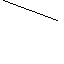

In [10]:
cv2_imshow(arr_data_img[50])

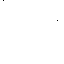

In [11]:
cv2_imshow(arr_label_img[50])

In [12]:
arr_start[50]

(57, 20)

In [13]:
arr_end[50]

(3, 0)

In [14]:
arr_data_img = arr_data_img.reshape((img_number, 64, 64, 1))
arr_data_img = arr_data_img.astype('float32') / 255

In [15]:
arr_label_img = arr_label_img.reshape((img_number, 64, 64, 1))
arr_label_img = arr_label_img.astype('float32') / 255

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(arr_data_img, arr_label_img, test_size=0.15, random_state=2018)

Model training

In [17]:
input_img = Input((64, 64, 1))
model = based_model(input_img)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                               

In [18]:
results = model.fit(X_train, y_train, batch_size=32, epochs=60,
                    validation_data=(X_valid, y_valid))

Epoch 1/60
54/54 [==============================] - 109s 2s/step - loss: 0.3632 - accuracy: 0.9702 - val_loss: 0.3491 - val_accuracy: 0.9995
Epoch 2/60
54/54 [==============================] - 105s 2s/step - loss: 0.1231 - accuracy: 0.9938 - val_loss: 0.1927 - val_accuracy: 0.9995
Epoch 3/60
54/54 [==============================] - 106s 2s/step - loss: 0.0500 - accuracy: 0.9982 - val_loss: 0.1585 - val_accuracy: 0.9995
Epoch 4/60
54/54 [==============================] - 104s 2s/step - loss: 0.0274 - accuracy: 0.9991 - val_loss: 0.1197 - val_accuracy: 0.9995
Epoch 5/60
54/54 [==============================] - 104s 2s/step - loss: 0.0182 - accuracy: 0.9994 - val_loss: 0.0823 - val_accuracy: 0.9995
Epoch 6/60
54/54 [==============================] - 106s 2s/step - loss: 0.0136 - accuracy: 0.9995 - val_loss: 0.0502 - val_accuracy: 0.9995
Epoch 7/60
54/54 [==============================] - 104s 2s/step - loss: 0.0108 - accuracy: 0.9995 - val_loss: 0.0282 - val_accuracy: 0.9995
Epoch 8/60
54

Plot of loss function

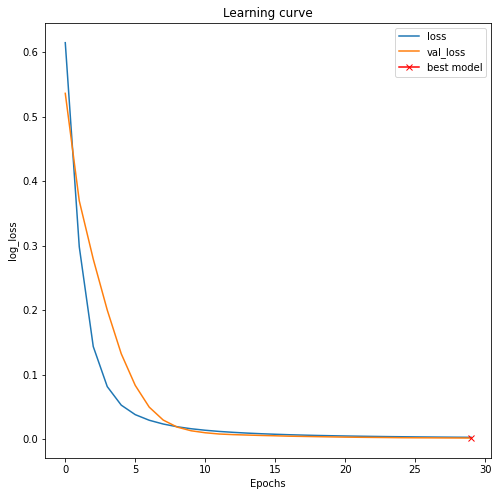

In [24]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

Model evaluation

In [25]:
model.evaluate(X_valid, y_valid, verbose=1)

10/10 [==============================] - 5s 534ms/step - loss: 0.0016 - accuracy: 0.9997


[0.0016026865923777223, 0.9996687769889832]

Predicting

In [26]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

10/10 [==============================] - 4s 408ms/step


Image of line from training set:


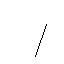

Image of edgepoints from training set:


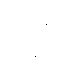

Predicted image of edgepoints from training set:


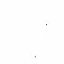

In [580]:
print('Image of line from training set:')
cv2_imshow(X_train[643] * 255)
print('Image of edgepoints from training set:')
cv2_imshow(y_train[643] * 255)
print('Predicted image of edgepoints from training set:')
cv2_imshow(preds_train[643] * 255)

Image of line from validation set:


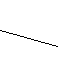

Image of edgepoints from validation set:


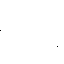

Predicted image of edgepoints from validation set:


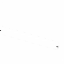

In [579]:
print('Image of line from validation set:')
cv2_imshow(X_valid[78] * 255)
print('Image of edgepoints from validation set:')
cv2_imshow(y_valid[78] * 255)
print('Predicted image of edgepoints from validation set:')
cv2_imshow(preds_val[78] * 255)

Saving model

In [ ]:
model.save('walksee_task_model.h5')

Testing model

1/1 [==============================] - 0s 42ms/step
Image of random line to predict:


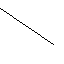

Predicted image with edgepoints:


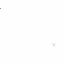

Number of tries: 18
Final factor: 0.84
Predicted points: (53, 44), (0, 8)
Actual points: (53, 44), (0, 8)


In [582]:
model_test_function()